In [ ]:
nu = 0.01

In [ ]:
class NavierStokes():
    def __init__(self, X, Y, T, u, v):
        # Initialize inputs
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True)

        self.u = torch.tensor(u, dtype=torch.float32)
        self.v = torch.tensor(v, dtype=torch.float32)
        self.null = torch.zeros((self.x.shape[0], 1))

        self.network()

        self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=0.1, max_iter=10000, max_eval=8000,
                                   history_size=50, tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,
                                   line_search_fn="strong_wolfe")

        self.mse = nn.MSELoss()

        self.ls = 0
        self.iter = 0

    def network(self):
        self.net = nn.Sequential(
            nn.Linear(3, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 2))


    def function(self, x, y, t):
        res = self.net(torch.hstack((x, y, t)))
        psi, p = res[:, 0:1], res[:, 1:2]
        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        v = -1. * torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        f = u_t + u * u_x + v * u_y + p_x - nu * (torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0] +
                                                  torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0])
        g = v_t + u * v_x + v * v_y + p_y - nu * (torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0] +
                                                  torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0])

        return u, v, p, f, g

    def closure(self):
      self.optimizer.zero_grad()
      u_prediction, v_prediction, p_prediction, f_prediction, g_prediction = self.function(self.x, self.y, self.t)

      u_loss = self.mse(u_prediction, self.u)  # Error between predicted and real u values
      v_loss = self.mse(v_prediction, self.v)  # Error between predicted and real v values
      f_loss = self.mse(f_prediction, self.null)  # Enforce Navier-Stokes residual for horizontal direction
      g_loss = self.mse(g_prediction, self.null)  # Enforce Navier-Stokes residual for vertical direction


      self.ls = u_loss + v_loss + f_loss + g_loss
      self.ls.backward()

      self.iter += 1
      if not self.iter % 100:
          print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls.item()))

      return self.ls

    def train(self):
      self.net.train()

      self.optimizer.step(self.closure)



In [ ]:
N_train = 5000

data = scipy.io.loadmat('cylinder_wake.mat')

In [ ]:
X_star = data['X_star']  # Spatial coordinates (N x 2)
U_star = data['U_star']  # Velocities (N x 2 x T)
P_star = data['p_star']  # Pressure (N x T)
t_star = data['t']  # Time (T x 1)

N = X_star.shape[0]
T = t_star.shape[0]
XX = np.tile(X_star[:, 0:1], (1, T)).flatten()[:, None]
YY = np.tile(X_star[:, 1:2], (1, T)).flatten()[:, None]
TT = np.tile(t_star, (1, N)).T.flatten()[:, None]
UU = U_star[:, 0, :].flatten()[:, None]
VV = U_star[:, 1, :].flatten()[:, None]

idx = np.random.choice(N * T, N_train, replace=False)
x_train = XX[idx, :]
y_train = YY[idx, :]
t_train = TT[idx, :]
u_train = UU[idx, :]
v_train = VV[idx, :]


In [ ]:
pinn = NavierStokes(x_train, y_train, t_train, u_train, v_train)
pinn.train()

Iteration: 100, Loss: 0.095579
Iteration: 200, Loss: 0.079807
Iteration: 300, Loss: 0.073595
Iteration: 400, Loss: 0.069768
Iteration: 500, Loss: 0.067365
Iteration: 600, Loss: 0.065033
Iteration: 700, Loss: 0.063282
Iteration: 800, Loss: 0.062160
Iteration: 900, Loss: 0.060910
Iteration: 1000, Loss: 0.059812
Iteration: 1100, Loss: 0.058789
Iteration: 1200, Loss: 0.057949
Iteration: 1300, Loss: 0.057146
Iteration: 1400, Loss: 0.056376
Iteration: 1500, Loss: 0.055568
Iteration: 1600, Loss: 0.053827
Iteration: 1700, Loss: 0.052647
Iteration: 1800, Loss: 0.051371
Iteration: 1900, Loss: 0.049742
Iteration: 2000, Loss: 0.048419
Iteration: 2100, Loss: 0.047137
Iteration: 2200, Loss: 0.045987
Iteration: 2300, Loss: 0.044948
Iteration: 2400, Loss: 0.043786
Iteration: 2500, Loss: 0.042923
Iteration: 2600, Loss: 0.041758
Iteration: 2700, Loss: 0.040711
Iteration: 2800, Loss: 0.039791
Iteration: 2900, Loss: 0.038974
Iteration: 3000, Loss: 0.038287
Iteration: 3100, Loss: 0.037392
Iteration: 3200, 

In [ ]:
x_test = X_star[:, 0:1]
y_test = X_star[:, 1:2]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))  # Let's assume we're evaluating at time t=1 for simplicity

x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)


u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, t_test)


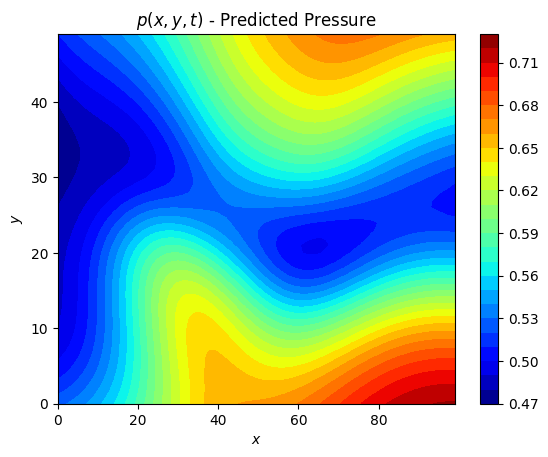

In [ ]:
p_plot = p_out.data.cpu().numpy()
p_plot = np.reshape(p_plot, (50, 100))


fig, ax = plt.subplots()
plt.contourf(p_plot, levels=30, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$p(x, y, t)$ - Predicted Pressure')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

u_plot = u_out.data.cpu().numpy()
v_plot = v_out.data.cpu().numpy()
f_plot = f_out.data.cpu().numpy()
g_plot = g_out.data.cpu().numpy()


plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.plot(u_plot)
plt.title('u')
plt.xlabel('Index')
plt.ylabel('Value')

plt.subplot(1, 4, 2)
plt.plot(v_plot)
plt.title('v')
plt.xlabel('Index')
plt.ylabel('Value')

plt.subplot(1, 4, 3)
plt.plot(f_plot)
plt.title('f')
plt.xlabel('Index')
plt.ylabel('Value')

plt.subplot(1, 4, 4)
plt.plot(g_plot)
plt.title('g')
plt.xlabel('Index')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

# Transient flow of data

In [ ]:
import scipy.io
import numpy as np

# Load the dataset
data = scipy.io.loadmat('cylinder_wake.mat')

# Inspect the data keys to see available variables
print(data.keys())

# Extract relevant information from the dataset
U_star = data['U_star']  # Velocity components (N x 2 x T)
P_star = data['p_star']  # Pressure (N x T)
t_star = data['t']       # Time points (T x 1)
X_star = data['X_star']  # Spatial coordinates (N x 2)

print("Velocity data shape:", U_star.shape)
print("Pressure data shape:", P_star.shape)
print("Time points shape:", t_star.shape)
print("Spatial coordinates shape:", X_star.shape)


dict_keys(['__header__', '__version__', '__globals__', 'X_star', 't', 'U_star', 'p_star'])
Velocity data shape: (5000, 2, 200)
Pressure data shape: (5000, 200)
Time points shape: (200, 1)
Spatial coordinates shape: (5000, 2)


In [ ]:

x_star = X_star[:, 0:1]  # x coordinates (N x 1)
y_star = X_star[:, 1:2]  # y coordinates (N x 1)
t_star = t_star.flatten()  # Time points (T, )

N = x_star.shape[0]
T = len(t_star)

XX = np.tile(x_star, (1, T))  # N x T
YY = np.tile(y_star, (1, T))  # N x T
TT = np.tile(t_star, (N, 1))  # N x T

UU = U_star[:, 0, :]  # x-velocity (N x T)
VV = U_star[:, 1, :]  # y-velocity (N x T)
PP = P_star           # Pressure (N x T)

x = XX.flatten()[:, None]
y = YY.flatten()[:, None]
t = TT.flatten()[:, None]
u = UU.flatten()[:, None]
v = VV.flatten()[:, None]
p = PP.flatten()[:, None]

N_train = 5000  # You can adjust this number for faster training
idx = np.random.choice(N * T, N_train, replace=False)

x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

print(f"Number of training samples: {x_train.shape[0]}")


Number of training samples: 5000


In [ ]:
import torch
import torch.nn as nn

class TransientNavierStokes():
    def __init__(self, X, Y, T, u, v):
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True)

        self.u = torch.tensor(u, dtype=torch.float32)
        self.v = torch.tensor(v, dtype=torch.float32)

        self.null = torch.zeros((self.x.shape[0], 1))

        self.network()

        self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=0.01, max_iter=10000, max_eval=8000,
                                           history_size=50, tolerance_grad=1e-05,
                                           tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        self.mse = nn.MSELoss()
        self.ls = 0
        self.iter = 0

    def network(self):
        self.net = nn.Sequential(
            nn.Linear(3, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 3))  # Output: [u, v, p]

    def function(self, x, y, t):
        res = self.net(torch.hstack((x, y, t)))
        u, v, p = res[:, 0:1], res[:, 1:2], res[:, 2:3]

        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]


        f = u_t + u * u_x + v * u_y + p_x - nu * (u_x + u_y)
        g = v_t + u * v_x + v * v_y + p_y - nu * (v_x + v_y)

        return u, v, p, f, g


    def closure(self):
        self.optimizer.zero_grad()

        u_prediction, v_prediction, p_prediction, f_prediction, g_prediction = self.function(self.x, self.y, self.t)

        u_loss = self.mse(u_prediction, self.u)
        v_loss = self.mse(v_prediction, self.v)

        f_loss = self.mse(f_prediction, self.null)
        g_loss = self.mse(g_prediction, self.null)

        self.ls = u_loss + v_loss + f_loss + g_loss


        self.ls.backward()


        self.iter += 1
        if not self.iter % 10:  # Print every 10 iterations
            print(f'Iteration: {self.iter}, Loss: {self.ls.item():.6f}')

        return self.ls

    def train(self):
        self.net.train()
        self.optimizer.step(self.closure)


In [ ]:
pinn_transient = TransientNavierStokes(x_train, y_train, t_train, u_train, v_train)


pinn_transient.train()


torch.save(pinn_transient.net.state_dict(), 'transient_model.pt')


Iteration: 10, Loss: 0.156012
Iteration: 20, Loss: 0.155991
Iteration: 30, Loss: 0.155983
Iteration: 40, Loss: 0.155979
Iteration: 50, Loss: 0.155958
Iteration: 60, Loss: 0.155787
Iteration: 70, Loss: 0.155466
Iteration: 80, Loss: 0.155400
Iteration: 90, Loss: 0.155377
Iteration: 100, Loss: 0.155343
Iteration: 110, Loss: 0.155039
Iteration: 120, Loss: 0.154558
Iteration: 130, Loss: 0.154074
Iteration: 140, Loss: 0.153428
Iteration: 150, Loss: 0.150727
Iteration: 160, Loss: 0.145012
Iteration: 170, Loss: 0.134181
Iteration: 180, Loss: 0.128133
Iteration: 190, Loss: 0.123972
Iteration: 200, Loss: 0.118893
Iteration: 210, Loss: 0.116665
Iteration: 220, Loss: 0.114250
Iteration: 230, Loss: 0.112777
Iteration: 240, Loss: 0.109416
Iteration: 250, Loss: 0.107290
Iteration: 260, Loss: 0.103623
Iteration: 270, Loss: 0.102096
Iteration: 280, Loss: 0.101356
Iteration: 290, Loss: 0.100638
Iteration: 300, Loss: 0.100160
Iteration: 310, Loss: 0.099785
Iteration: 320, Loss: 0.099463
Iteration: 330, L

In [ ]:
# Load the trained model for inference
pinn_transient = TransientNavierStokes(x_train, y_train, t_train, u_train, v_train)
pinn_transient.net.load_state_dict(torch.load('transient_model.pt'))
pinn_transient.net.eval()  # Set the model to evaluation mode


<ipython-input-42-7f8a57dda9e9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pinn_transient.net.load_state_dict(torch.load('transient_model.pt'))


Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): Tanh()
  (10): Linear(in_features=20, out_features=20, bias=True)
  (11): Tanh()
  (12): Linear(in_features=20, out_features=20, bias=True)
  (13): Tanh()
  (14): Linear(in_features=20, out_features=20, bias=True)
  (15): Tanh()
  (16): Linear(in_features=20, out_features=3, bias=True)
)

In [ ]:
x_test = np.linspace(0, 1.1, 100)  # Example range for x coordinates
y_test = np.linspace(0, 0.41, 50)  # Example range for y coordinates
t_test = np.array([0.1])


x_test, y_test = np.meshgrid(x_test, y_test)
x_test = x_test.flatten()[:, None]
y_test = y_test.flatten()[:, None]
t_test = np.ones_like(x_test) * t_test  # Same time for all test points


x_test_tensor = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)


u_out, v_out, p_out, _, _ = pinn_transient.function(x_test_tensor, y_test_tensor, t_test_tensor)


In [ ]:
def animate(i):

    t_test = np.ones_like(x_test) * t_star[i]
    t_test_tensor = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)

    with torch.no_grad():
        u_out, v_out, p_out, _, _ = pinn_transient.function(x_test_tensor, y_test_tensor, t_test_tensor)

    u_plot = u_out.data.cpu().numpy().reshape((50, 100))
    v_plot = v_out.data.cpu().numpy().reshape((50, 100))
    p_plot = p_out.data.cpu().numpy().reshape((50, 100))

    u_contour = ax[0].contourf(u_plot, levels=30, cmap='jet')
    ax[0].set_title('u Velocity Field')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    fig.colorbar(u_contour, ax=ax[0])

    v_contour = ax[1].contourf(v_plot, levels=30, cmap='jet')
    ax[1].set_title('v Velocity Field')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    fig.colorbar(v_contour, ax=ax[1])

    p_contour = ax[2].contourf(p_plot, levels=30, cmap='jet')
    ax[2].set_title('Pressure Field')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')
    fig.colorbar(p_contour, ax=ax[2])

    plt.tight_layout()
